<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/Importing_data_with_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Lavorare con il database in SQL e Pandas*

In [1]:
import urllib.request
print('Beginning file download with urllib2...')
url = 'https://github.com/thimotyb/real-world-machine-learning/raw/python3/flights.db'
urllib.request.urlretrieve(url, 'flights.db')

Beginning file download with urllib2...


('flights.db', <http.client.HTTPMessage at 0x7f5360fe2750>)

In [2]:
# Dimostrazione di collegamento a database usando SQLLite

import pandas as pd
import sqlite3
conn = sqlite3.connect("flights.db")
df = pd.read_sql_query("select * from airlines limit 5;", conn)
df

,index,id,name,alias,iata,icao,callsign,country,active
0,0,1,Private flight,\N,-,None,None,None,Y
1,1,2,135 Airways,\N,None,GNL,GENERAL,United States,N
2,2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,3,4,2 Sqn No 1 Elementary Flying Training School,\N,None,WYT,None,United Kingdom,N
4,4,5,213 Flight Unit,\N,None,TFU,None,Russia,N


In [ ]:
# Prelievo senza dataframe
cur = conn.cursor()
cur.execute("select * from airlines limit 5;")
results = cur.fetchall()
print(results)

[(0, '1', 'Private flight', '\\N', '-', None, None, None, 'Y'), (1, '2', '135 Airways', '\\N', None, 'GNL', 'GENERAL', 'United States', 'N'), (2, '3', '1Time Airline', '\\N', '1T', 'RNX', 'NEXTIME', 'South Africa', 'Y'), (3, '4', '2 Sqn No 1 Elementary Flying Training School', '\\N', None, 'WYT', None, 'United Kingdom', 'N'), (4, '5', '213 Flight Unit', '\\N', None, 'TFU', None, 'Russia', 'N')]


In [ ]:
# Inserimento
cur.execute("insert into airlines values (6048, 19846, 'Test flight', '', '', null, null, null, 'Y')")


In [ ]:
cur.execute("select * from airlines where name = 'Test flight';")
results = cur.fetchall()
print(results)

[(6048, '19846', 'Test flight', '', '', None, None, None, 'Y'), (6048, '19846', 'Test flight', '', '', None, None, None, 'Y')]


In [ ]:
# Uso di parametri per evitare sql injection

# Non così
#name = 'Test Flight'
#cur.execute("insert into airlines values (6049, 19847, {0}, '', '', null, null, null, 'Y')".format(name))

# Ma così
values = ('Test Flight', 'Y')
cur.execute("insert into airlines values (6049, 19847, ?, '', '', null, null, null, ?)", values)

In [ ]:
cur.execute("select * from airlines where name = 'Test Flight';")
results = cur.fetchall()
print(results)

[(6049, '19847', 'Test Flight', '', '', None, None, None, 'Y'), (6049, '19847', 'Test Flight', '', '', None, None, None, 'Y')]


In [ ]:
# Creare tabelle direttamente con SQL
cur.execute("create table daily_flights (id integer, departure date, arrival date, number text, route_id integer)")
cur.execute("insert into daily_flights values (1, '2016-09-28 0:00', '2016-09-28 12:00', 'T1', 1)")


In [ ]:
pd.read_sql_query("select * from daily_flights;", conn)

,id,departure,arrival,number,route_id
0,1,2016-09-28 0:00,2016-09-28 12:00,T1,1


In [ ]:
# Creare tabelle e manipolare dati in SQL con Pandas
from datetime import datetime
df = pd.DataFrame(
[[1, datetime(2016, 9, 29, 0, 0) ,
datetime(2016, 9, 29, 12, 0), 'T1', 1]],
columns=["id", "departure", "arrival", "number", "route_id"])

In [ ]:
df.to_sql("daily_flights", conn, if_exists="replace")

In [ ]:
pd.read_sql_query("select * from daily_flights;", conn)

,index,id,departure,arrival,number,route_id
0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1


In [ ]:
# Possibilità di Alter Table
df = pd.read_sql("select * from daily_flights", conn)
df["delay_minutes"] = None
df.to_sql("daily_flights", conn, if_exists="replace")

In [ ]:
df

,index,id,departure,arrival,number,route_id,delay_minutes
0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1,None


Lavorare con SQLAlchemy

In [ ]:
# https://towardsdatascience.com/sqlalchemy-python-tutorial-79a577141a91
import sqlalchemy as db
import pandas as pd

import urllib.request
print('Beginning file download with urllib2...')
url = 'https://github.com/thimotyb/hacking-datascience/raw/master/notebooks/sqlalchemy/census.sqlite'
urllib.request.urlretrieve(url, 'census.sqlite')

engine = db.create_engine('sqlite:///census.sqlite')
connection = engine.connect()
metadata = db.MetaData()

census = db.Table('census', metadata, autoload=True, autoload_with=engine)
state_fact = db.Table('state_fact', metadata, autoload=True, autoload_with=engine)

Beginning file download with urllib2...


In [ ]:
# Querying
query = db.select([census]).where(db.and_(census.columns.state == 'California', census.columns.sex != 'M'))
result = connection.execute(query).fetchall()
result[:3]

[('California', 'F', 0, 239605, 274356),
 ('California', 'F', 1, 236543, 269140),
 ('California', 'F', 2, 240010, 262556)]

In [ ]:
query = db.select([census.columns.state, census.columns.sex]).order_by(db.desc(census.columns.state))
result = connection.execute(query).fetchall()
result[:3]

[('Wyoming', 'M'), ('Wyoming', 'M'), ('Wyoming', 'M')]

In [ ]:
query = db.select([db.func.max(census.columns.pop2008)])
result = connection.execute(query).scalar()
result

400288

In [ ]:
# Convert to dataframe
query = db.select([census.columns.state.distinct()])
result = connection.execute(query).fetchall()
result[:3]

df = pd.DataFrame(result)
df.columns = result[0].keys()
df.head(2)

,state
0,Illinois
1,New Jersey


In [ ]:
# Automatic Join
metadata = db.MetaData()
census = db.Table('census', metadata, autoload=True, autoload_with=engine)
state_fact = db.Table('state_fact', metadata, autoload=True, autoload_with=engine)

query = db.select([census.columns.pop2008, state_fact.columns.abbreviation])
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,pop2008,abbreviation
0,95012,IL
1,95012,NJ
2,95012,ND
3,95012,OR
4,95012,DC


In [ ]:
# Manual Join

query = db.select([census, state_fact])
query = query.select_from(census.join(state_fact, census.columns.state == state_fact.columns.name))
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,state,sex,age,pop2000,pop2008,id,name,abbreviation,country,type,sort,status,occupied,notes,fips_state,assoc_press,standard_federal_region,census_region,census_region_name,census_division,census_division_name,circuit_court
0,Illinois,M,0,89600,95012,13,Illinois,IL,USA,state,10,current,occupied,,17,Ill.,V,2,Midwest,3,East North Central,7
1,Illinois,M,1,88445,91829,13,Illinois,IL,USA,state,10,current,occupied,,17,Ill.,V,2,Midwest,3,East North Central,7
2,Illinois,M,2,88729,89547,13,Illinois,IL,USA,state,10,current,occupied,,17,Ill.,V,2,Midwest,3,East North Central,7
3,Illinois,M,3,88868,90037,13,Illinois,IL,USA,state,10,current,occupied,,17,Ill.,V,2,Midwest,3,East North Central,7
4,Illinois,M,4,91947,91111,13,Illinois,IL,USA,state,10,current,occupied,,17,Ill.,V,2,Midwest,3,East North Central,7


*Lavorare con Excel*

In [ ]:
excel_file = 'https://github.com/thimotyb/real-world-machine-learning/raw/python3/movies.xls'
movies = pd.read_excel(excel_file)

In [ ]:
movies.head(5)

,Title,Year,Genres,Language,Country,Content Rating,Duration,Aspect Ratio,Budget,Gross Earnings,Director,Actor 1,Actor 2,Actor 3,Facebook Likes - Director,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
0,Intolerance: Love's Struggle Throughout the Ages,1916,Drama|History|War,NaN,USA,Not Rated,123,1.33,385907.0,NaN,D.W. Griffith,Lillian Gish,Mae Marsh,Walter Long,204,436,22,9.0,481,691,1,10718,88,69.0,8.0
1,Over the Hill to the Poorhouse,1920,Crime|Drama,NaN,USA,NaN,110,1.33,100000.0,3000000.0,Harry F. Millarde,Stephen Carr,Johnnie Walker,Mary Carr,0,2,2,0.0,4,0,1,5,1,1.0,4.8
2,The Big Parade,1925,Drama|Romance|War,NaN,USA,Not Rated,151,1.33,245000.0,NaN,King Vidor,John Gilbert,Renée Adorée,Claire Adams,54,81,12,6.0,108,226,0,4849,45,48.0,8.3
3,Metropolis,1927,Drama|Sci-Fi,German,Germany,Not Rated,145,1.33,6000000.0,26435.0,Fritz Lang,Brigitte Helm,Gustav Fröhlich,Rudolf Klein-Rogge,756,136,23,18.0,203,12000,1,111841,413,260.0,8.3
4,Pandora's Box,1929,Crime|Drama|Romance,German,Germany,Not Rated,110,1.33,NaN,9950.0,Georg Wilhelm Pabst,Louise Brooks,Francis Lederer,Fritz Kortner,21,426,20,3.0,455,926,1,7431,84,71.0,8.0


In [ ]:
# Caricare un particolare Foglio del file Excel
movies_sheet1 = pd.read_excel(excel_file, sheet_name=0, index_col=0)
movies_sheet1.head(5)

,Year,Genres,Language,Country,Content Rating,Duration,Aspect Ratio,Budget,Gross Earnings,Director,Actor 1,Actor 2,Actor 3,Facebook Likes - Director,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
Title,,,,,,,,,,,,,,,,,,,,,,,,
Intolerance: Love's Struggle Throughout the Ages,1916,Drama|History|War,NaN,USA,Not Rated,123,1.33,385907.0,NaN,D.W. Griffith,Lillian Gish,Mae Marsh,Walter Long,204,436,22,9.0,481,691,1,10718,88,69.0,8.0
Over the Hill to the Poorhouse,1920,Crime|Drama,NaN,USA,NaN,110,1.33,100000.0,3000000.0,Harry F. Millarde,Stephen Carr,Johnnie Walker,Mary Carr,0,2,2,0.0,4,0,1,5,1,1.0,4.8
The Big Parade,1925,Drama|Romance|War,NaN,USA,Not Rated,151,1.33,245000.0,NaN,King Vidor,John Gilbert,Renée Adorée,Claire Adams,54,81,12,6.0,108,226,0,4849,45,48.0,8.3
Metropolis,1927,Drama|Sci-Fi,German,Germany,Not Rated,145,1.33,6000000.0,26435.0,Fritz Lang,Brigitte Helm,Gustav Fröhlich,Rudolf Klein-Rogge,756,136,23,18.0,203,12000,1,111841,413,260.0,8.3
Pandora's Box,1929,Crime|Drama|Romance,German,Germany,Not Rated,110,1.33,NaN,9950.0,Georg Wilhelm Pabst,Louise Brooks,Francis Lederer,Fritz Kortner,21,426,20,3.0,455,926,1,7431,84,71.0,8.0


In [ ]:
movies_sheet2 = pd.read_excel(excel_file, sheet_name=1, index_col=0)
movies_sheet2.head(5)

,Year,Genres,Language,Country,Content Rating,Duration,Aspect Ratio,Budget,Gross Earnings,Director,Actor 1,Actor 2,Actor 3,Facebook Likes - Director,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
Title,,,,,,,,,,,,,,,,,,,,,,,,
102 Dalmatians,2000,Adventure|Comedy|Family,English,USA,G,100.0,1.85,85000000.0,66941559.0,Kevin Lima,Ioan Gruffudd,Eric Idle,Jim Carter,36,2000.0,795.0,439.0,4182,372,1,26413,77.0,84.0,4.8
28 Days,2000,Comedy|Drama,English,USA,PG-13,103.0,1.37,43000000.0,37035515.0,Betty Thomas,Steve Buscemi,Viggo Mortensen,Elizabeth Perkins,84,12000.0,10000.0,664.0,23864,0,1,34597,194.0,116.0,6.0
3 Strikes,2000,Comedy,English,USA,R,82.0,1.85,6000000.0,9821335.0,DJ Pooh,Mo'Nique,Mike Epps,Faizon Love,69,939.0,706.0,585.0,3354,118,1,1415,10.0,22.0,4.0
Aberdeen,2000,Drama,English,UK,NaN,106.0,1.85,6500000.0,64148.0,Hans Petter Moland,Charlotte Rampling,Sara-Marie Maltha,Stellan Skarsgård,19,844.0,2.0,0.0,846,260,0,2601,35.0,28.0,7.3
All the Pretty Horses,2000,Drama|Romance|Western,English,USA,PG-13,220.0,2.35,57000000.0,15527125.0,Billy Bob Thornton,Matt Damon,Henry Thomas,Sam Shepard,0,13000.0,861.0,820.0,15006,652,2,11388,183.0,85.0,5.8


In [ ]:
movies_sheet3 = pd.read_excel(excel_file, sheet_name=2, index_col=0)
movies_sheet3.head()

,Year,Genres,Language,Country,Content Rating,Duration,Aspect Ratio,Budget,Gross Earnings,Director,Actor 1,Actor 2,Actor 3,Facebook Likes - Director,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
Title,,,,,,,,,,,,,,,,,,,,,,,,
127 Hours,2010.0,Adventure|Biography|Drama|Thriller,English,USA,R,94.0,1.85,18000000.0,18329466.0,Danny Boyle,James Franco,Treat Williams,Kate Burton,0.0,11000.0,642.0,223.0,11984,63000,0.0,279179,440.0,450.0,7.6
3 Backyards,2010.0,Drama,English,USA,R,88.0,NaN,300000.0,NaN,Eric Mendelsohn,Embeth Davidtz,Edie Falco,Kathryn Erbe,5.0,795.0,659.0,301.0,1884,92,0.0,554,23.0,20.0,5.2
3,2010.0,Comedy|Drama|Romance,German,Germany,Unrated,119.0,2.35,NaN,59774.0,Tom Tykwer,Devid Striesow,Sebastian Schipper,Sophie Rois,670.0,24.0,20.0,9.0,69,2000,0.0,4212,18.0,76.0,6.8
8: The Mormon Proposition,2010.0,Documentary,English,USA,R,80.0,1.78,2500000.0,99851.0,Reed Cowan,Dustin Lance Black,Emily Pearson,Gavin Newsom,0.0,191.0,12.0,5.0,210,0,0.0,1138,30.0,28.0,7.1
A Turtle's Tale: Sammy's Adventures,2010.0,Adventure|Animation|Family,English,France,PG,88.0,2.35,NaN,NaN,Ben Stassen,Ed Begley Jr.,Jenny McCarthy,Stacy Keach,4.0,783.0,749.0,602.0,3874,0,2.0,5385,22.0,56.0,6.1


In [ ]:
movies = pd.concat([movies_sheet1, movies_sheet2, movies_sheet3])
movies.shape

(5042, 24)

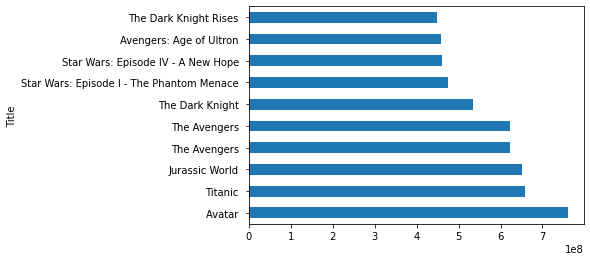

In [ ]:
# Small Data Analysis
sorted_by_gross = movies.sort_values(['Gross Earnings'], ascending=False)
import matplotlib.pyplot as plt
sorted_by_gross['Gross Earnings'].head(10).plot(kind="barh")
plt.show()

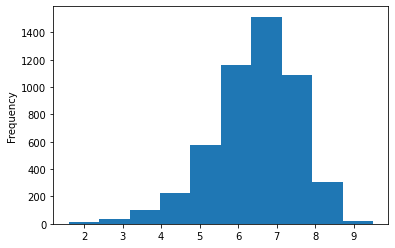

In [ ]:
movies['IMDB Score'].plot(kind="hist")
plt.show()

In [ ]:
# Describe, stat information
movies.describe()

,Year,Duration,Aspect Ratio,Budget,Gross Earnings,Facebook Likes - Director,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
count,4935.000000,5028.000000,4714.000000,4.551000e+03,4.159000e+03,4938.000000,5035.000000,5029.000000,5020.000000,5042.000000,5042.000000,5029.000000,5.042000e+03,5022.000000,4993.000000,5042.000000
mean,2002.470517,107.201074,2.220403,3.975262e+07,4.846841e+07,686.621709,6561.323932,1652.080533,645.009761,9700.959143,7527.457160,1.371446,8.368475e+04,272.770808,140.194272,6.442007
std,12.474599,25.197441,1.385113,2.061149e+08,6.845299e+07,2813.602405,15021.977635,4042.774685,1665.041728,18165.101925,19322.070537,2.013683,1.384940e+05,377.982886,121.601675,1.125189
min,1916.000000,7.000000,1.180000,2.180000e+02,1.620000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,1.000000,1.000000,1.600000
25%,1999.000000,93.000000,1.850000,6.000000e+06,5.340988e+06,7.000000,614.500000,281.000000,133.000000,1411.250000,0.000000,0.000000,8.599250e+03,65.000000,50.000000,5.800000
50%,2005.000000,103.000000,2.350000,2.000000e+07,2.551750e+07,49.000000,988.000000,595.000000,371.500000,3091.000000,166.000000,1.000000,3.437100e+04,156.000000,110.000000,6.600000
75%,2011.000000,118.000000,2.350000,4.500000e+07,6.230944e+07,194.750000,11000.000000,918.000000,636.000000,13758.750000,3000.000000,2.000000,9.634700e+04,326.000000,195.000000,7.200000
max,2016.000000,511.000000,16.000000,1.221550e+10,7.605058e+08,23000.000000,640000.000000,137000.000000,23000.000000,656730.000000,349000.000000,43.000000,1.689764e+06,5060.000000,813.000000,9.500000


In [ ]:
# Pivot analysis in Pandas
movies_subset = movies[['Year', 'Gross Earnings']]
movies_subset.head()


,Year,Gross Earnings
Title,,
Intolerance: Love's Struggle Throughout the Ages,1916.0,NaN
Over the Hill to the Poorhouse,1920.0,3000000.0
The Big Parade,1925.0,NaN
Metropolis,1927.0,26435.0
Pandora's Box,1929.0,9950.0


In [ ]:
earnings_by_year = movies_subset.pivot_table(index=['Year'])
earnings_by_year.head()

,Gross Earnings
Year,
1920.0,3000000.0
1927.0,26435.0
1929.0,1408975.0
1933.0,2300000.0
1935.0,3000000.0


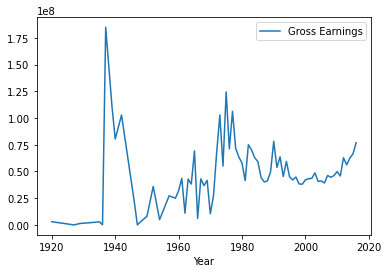

In [ ]:
earnings_by_year.plot()
plt.show()

In [ ]:
# Multicolumn pivot analysis
movies_subset = movies[['Country', 'Language', 'Gross Earnings']]
movies_subset.head()

,Country,Language,Gross Earnings
Title,,,
Intolerance: Love's Struggle Throughout the Ages,USA,NaN,NaN
Over the Hill to the Poorhouse,USA,NaN,3000000.0
The Big Parade,USA,NaN,NaN
Metropolis,Germany,German,26435.0
Pandora's Box,Germany,German,9950.0


In [ ]:
earnings_by_co_lang = movies_subset.pivot_table(index=['Country', 'Language'])
earnings_by_co_lang.head()

Gross Earnings
Country     Language                  
Afghanistan Dari          1.127331e+06
Argentina   Spanish       7.230936e+06
Aruba       English       1.007614e+07
Australia   Aboriginal    6.165429e+06
            Dzongkha      5.052950e+05

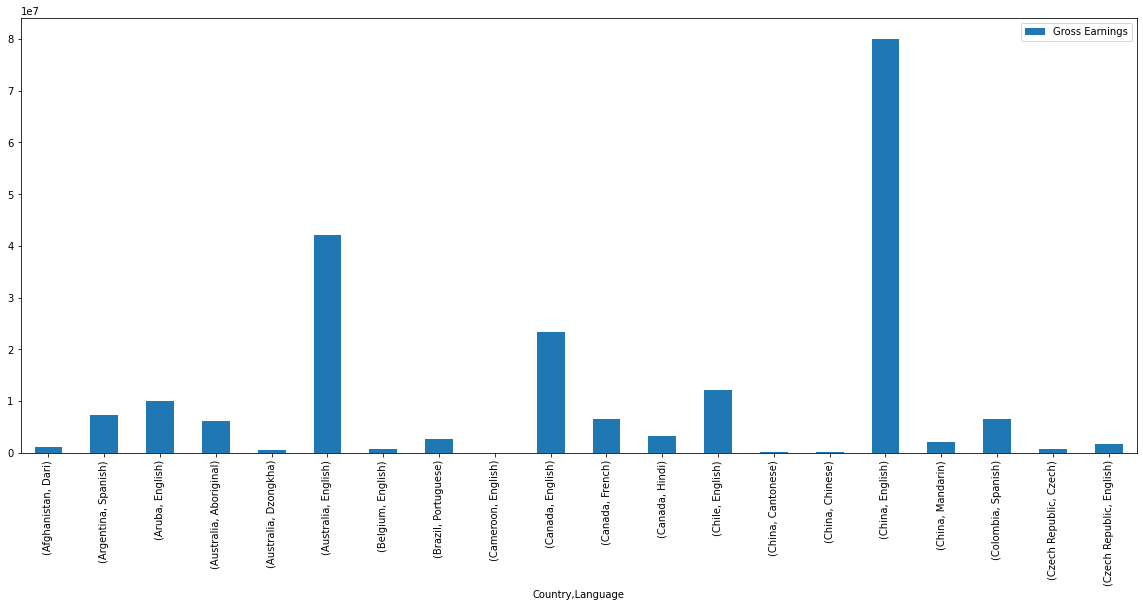

In [ ]:
earnings_by_co_lang.head(20).plot(kind='bar', figsize=(20,8))
plt.show()

In [ ]:
# Exporting to Excel

In [ ]:
movies.to_excel('output.xlsx')